In [1]:
%load_ext autoreload
%load_ext line_profiler
import sys
sys.path.append("..")

In [131]:
%autoreload

import numpy as np
import pickle

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


import main

import darkhistory.physics as phys
import darkhistory.utilities as utils

from darkhistory.spec import spectools
from darkhistory.spec.spectrum import Spectrum

In [68]:
direc = '/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/complete/'

(highengphot_tf_interp,
     lowengphot_tf_interp,
     lowengelec_tf_interp,
     highengdep_interp,
     CMB_engloss_interp
    ) = main.load_trans_funcs(direc)

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Generating TransferFuncInterp objects for each tflist...
Done.



In [69]:
ics_thomson_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_thomson_ref_tf.raw", "rb")) 
ics_rel_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_rel_ref_tf.raw", "rb"))
engloss_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/engloss_ref_tf.raw", "rb"))

In [139]:
eleceng = lowengelec_tf_interp.eng
photeng = lowengphot_tf_interp.eng

mDM = 2e8
tau = 3e25

# kinetic energy!
elec_spec_init = spectools.rebin_N_arr(np.array([2]), np.array([(mDM - phys.me)/2]), eleceng)
elec_spec_init.rs = 3000

phot_spec_init = Spectrum(photeng, np.zeros_like(photeng), rs = 3000)

# phot_spec_init = spectools.rebin_N_arr(np.array([2]), np.array([mDM/2]), photeng)
# phot_spec_init.rs = 3000

# elec_spec_init = Spectrum(eleceng, np.zeros_like(eleceng), rs=3000)

if elec_spec_init.spec_type == 'dNdE':
    elec_spec_init.switch_spec_type()
if phot_spec_init.spec_type == 'dNdE':
    phot_spec_init.switch_spec_type()
    
def rate_func_N(rs):
    return phys.rho_DM*rs**3/tau/mDM

def rate_func_eng(rs):
    return phys.rho_DM*rs**3/tau

b_elec_2e8_full_backr = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 4,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp, ics_only=True,
    ics_thomson_ref_tf=ics_thomson_ref_tf, ics_rel_ref_tf=ics_rel_ref_tf, engloss_ref_tf=engloss_ref_tf,
    coarsen_factor=15,std_soln=False, user=None, verbose=True
)



AHHHH YEAHHHH!
completed rs:  3000
completed rs:  2955.3358188091865
completed rs:  2911.336600645524
completed rs:  2867.9924454993
completed rs:  2825.2936007527474
completed rs:  2783.230458985661
completed rs:  2741.793555813688
completed rs:  2700.9735677588005
completed rs:  2660.761310151477
completed rs:  2621.147735064109
completed rs:  2582.1239292751798
completed rs:  2543.6811122637546
completed rs:  2505.8106342338237
completed rs:  2468.5039741680635
completed rs:  2431.7527379105704
completed rs:  2395.5486562781407
completed rs:  2359.8835831996703
completed rs:  2324.7494938832533
completed rs:  2290.138483010571
completed rs:  2256.04276295816
completed rs:  2222.454662045166
completed rs:  2189.3666228071834
completed rs:  2156.771200295792
completed rs:  2124.661060403414
completed rs:  2093.0289782131076
completed rs:  2061.8678363729314
completed rs:  2031.1706234945093
completed rs:  2000.9304325754388
completed rs:  1971.1404594451865
completed rs:  1941.7940012

completed rs:  76.04821656818072
completed rs:  74.91600612683429
completed rs:  73.80065210292068
completed rs:  72.70190353707906
completed rs:  71.61951320624674
completed rs:  70.55323756803291
completed rs:  69.50283670592059
completed rs:  68.4680742752844
completed rs:  67.44871745021199
completed rs:  66.4445368711173
completed rs:  65.45530659313359
completed rs:  64.48080403527499
completed rs:  63.52080993035475
completed rs:  62.57510827564927
completed rs:  61.64348628429653
completed rs:  60.72573433741817
completed rs:  59.82164593695433
completed rs:  58.93101765920077
completed rs:  58.05364910903763
completed rs:  57.18934287483969
completed rs:  56.33790448405794
completed rs:  55.49914235946241
completed rs:  54.672867776036526
completed rs:  53.85889481851312
completed rs:  53.057040339542795
completed rs:  52.267123918484934
completed rs:  51.48896782081231
completed rs:  50.72239695812009
completed rs:  49.96723884873016
completed rs:  49.223323578882066
complete

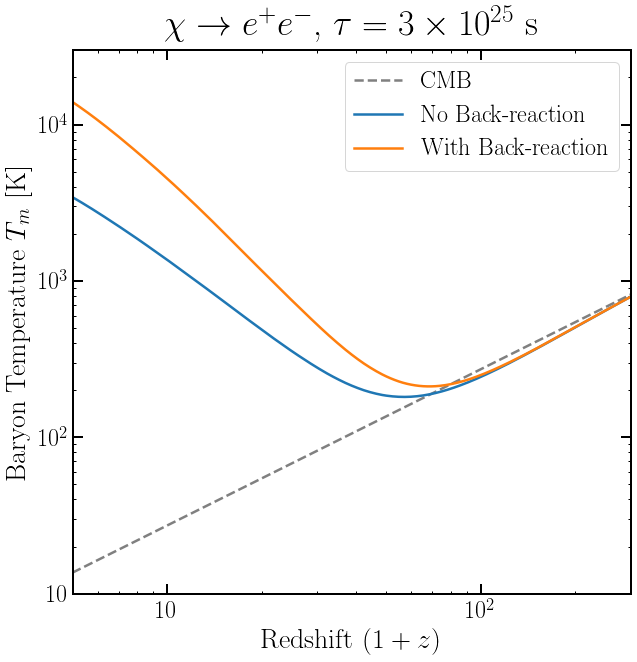

In [152]:
rs_vec = b_elec_2e8_full_std[3].rs
T_m_std = b_elec_2e8_full_std[1]
T_m_backr = b_elec_2e8_full_backr[1]
# x_e = b_elec_2e8_full_std[0]
plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Baryon Temperature $T_m$ [K]')
plt.title(r'$\chi \to e^+e^-$, $\tau = 3 \times 10^{25}$ s')

plt.axis([5, 300, 10, 3e4])

plt.plot(rs_vec[1:], phys.TCMB(rs_vec[1:])/phys.kB, color='gray', linestyle='--', label='CMB')
plt.plot(rs_vec[1:], T_m_std/phys.kB, label='No Back-reaction')
plt.plot(rs_vec[1:], T_m_backr/phys.kB, label='With Back-reaction')

plt.legend()

plt.savefig(
        '/Users/hongwan/Desktop/backreaction.pdf'
)
# plt.plot(rs_vec[1:], x_e)

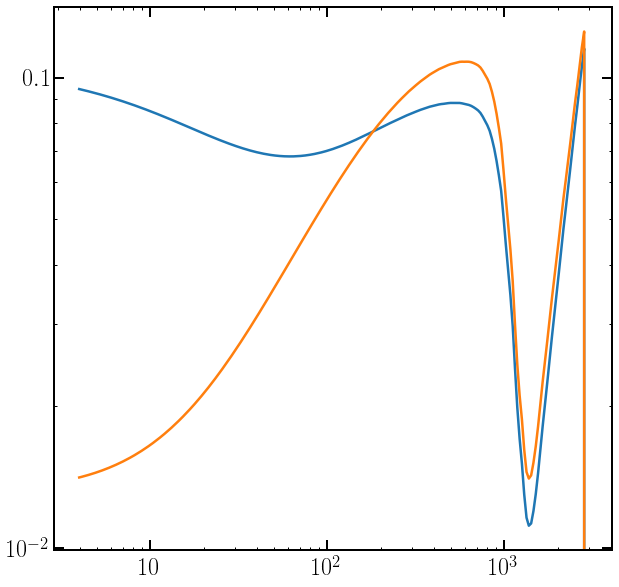

In [102]:
rs_vec = a[3].rs

plt.figure()
ax = plt.gca()
ax.loglog()

# mDM = 1e5, electrons, without prompt high-energy deposition
# plt.plot(rs_vec[1:], a[5][:,3])
# mDM = 1e5, electrons, with prompt high-energy deposition
plt.plot(rs_vec[1:], b_elec_2e5_full[5][:,2])
# mDM = phys.me + 2e4, electrons, with prompt high-energy deposition
plt.plot(rs_vec[1:], b_elec_2e4_full[5][:,2])
# # mDM = 1e5, photons
# plt.plot(rs_vec[1:], c_phot_test[5][:,3])
# # Electrons mDM = 1e8, ics_only
# plt.plot(rs_vec[1:], c_elec_1e8[5][:,3])

In [130]:
from scipy.interpolate import interp1d

soln = pickle.load(open("/Users/hongwan/GitHub/DarkHistory/darkhistory/history/std_soln.p", "rb"))
xe_std = interp1d(soln[0,:], soln[2,:])
Tm_std = interp1d(soln[0,:], soln[1,:])

print(Tm_std(3000)/phys.kB,phys.TCMB(3000)/phys.kB)

8176.497722775554 8176.499999999999
